<a href="https://colab.research.google.com/github/ContiPaolo/Multifidelity-Tutorial/blob/main/MF_POD_Burger's1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creation of the Multilevel dataset

Here we compute for each sample the coarse FEM solution that will then be given as imput to the NN of the fine level

#### Import libraries

In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['KERAS_BACKEND'] = 'tensorflow'
import numpy as np
#import matplotlib as plt
from matplotlib import pyplot as plt
from itertools import product
import timeit
import pandas as pd 
from keras.optimizers import Adam,Nadam,Adamax
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Dropout
from keras.models import Sequential
from keras.callbacks import LearningRateScheduler
from keras.models import load_model
from sklearn.utils import extmath
from fenics import *

import sys
sys.path.append('./solver')
from model import *
#######################     CONFIGURATIONS     ##########################
seed = 29
train = True
save = True

2024-07-28 12:50:55.497781: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Import the dataset 

In [2]:
X_train = np.loadtxt('./data/X_train_64000.csv', delimiter = ',')
y_train = np.loadtxt('./data/y_train_64000.csv', delimiter = ',')

X_test = np.loadtxt('./data/X_test_64000.csv', delimiter = ',')
y_test = np.loadtxt('./data/y_test_64000.csv',delimiter = ',')

Define the solvers

In [3]:
# set dataponts
x_data = y_data = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
datapoints = np.array(list(product(x_data, y_data)))
n_datapoints = len(x_data)*len(y_data)

# Set up the model(s)
solver_f = Model(resolution = [50,50], field_mean = 1, field_stdev = 1, mkl = 64, lamb = 0.1)
solver_c = Model(resolution = [25,25], field_mean = 1, field_stdev = 1, mkl = 64, lamb = 0.1)

#solver_c.random_process.eigenvectors = solver_f.random_process.eigenvectors
solver_c.random_process.eigenvalues = solver_f.random_process.eigenvalues

def solver_fine(x):
    solver_f.solve(x)
    return 0#solver_f.get_data(datapoints)


def solver_coarse(x):
    solver_c.solve(x)
    return 0#solver_c.get_data2()

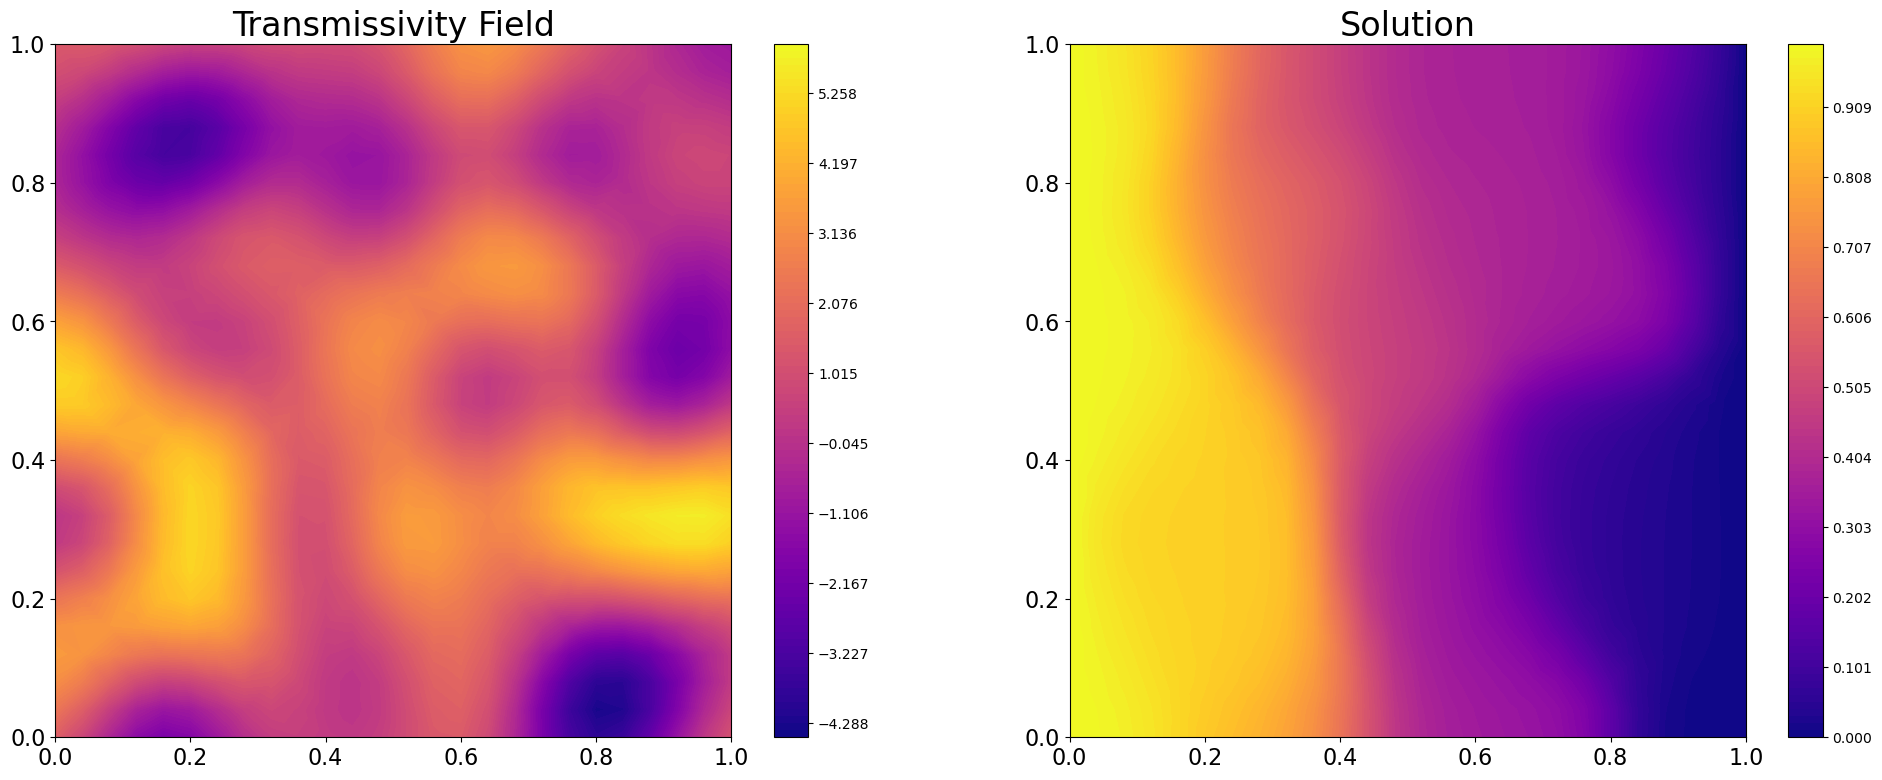

In [4]:
solver_c.solve(np.ones(64))
true_parameters = solver_c.random_process.parameters
solver_c.plot(limits=[-4.5, 6],transform_field=False)

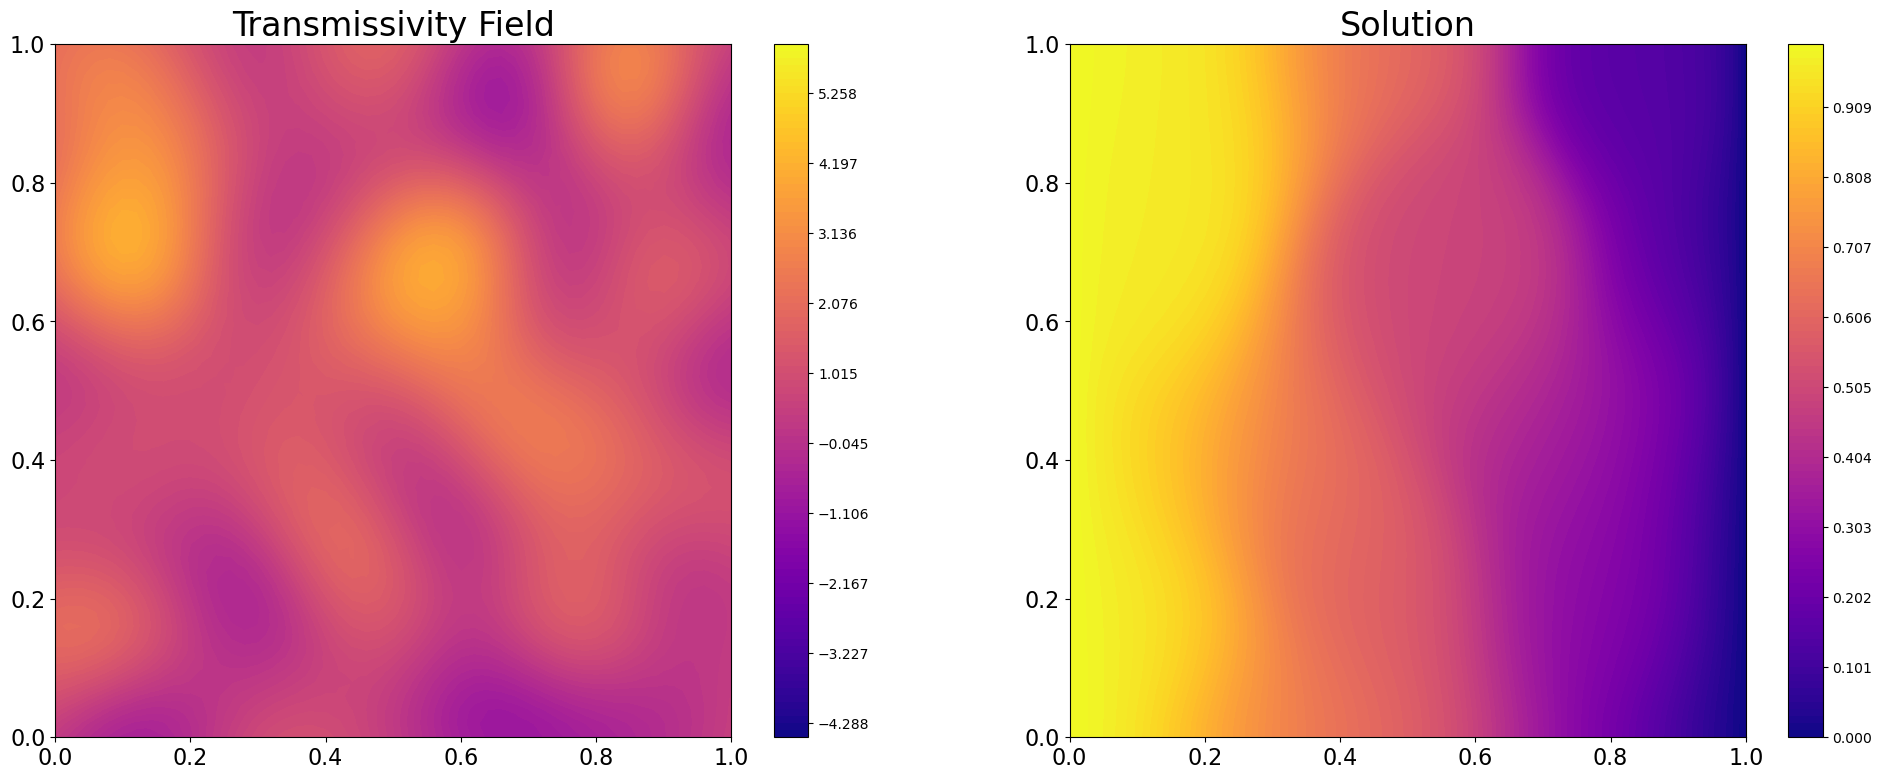

In [13]:
solver_f.solve(np.ones(64))
true_parameters = solver_f.random_process.parameters
solver_f.plot(limits=[-4.5, 6],transform_field=False)

Compare the time for each solver

In [14]:
start_0 = timeit.default_timer() 
coarse_predictions = [solver_coarse(X_train[i,:]) for i in range(1000)]
end_0 = timeit.default_timer()
 
start_1 = timeit.default_timer() 
fine_predictions = [solver_fine(X_train[i,:]) for i in range(1000)]
end_1= timeit.default_timer()

print('Time Coarse', (end_0-start_0)/1000)
print('Time Fine', (end_1-start_1)/1000)
print('\nThe speedup coefficient is:', (end_1 - start_1)/(end_0-start_0))

Time Coarse 0.0051999651659971275
Time Fine 0.009975492834000762

The speedup coefficient is: 1.9183768574511006


# Time comparison with LOW FIDELITY MODEL

Load low fidelity model

In [14]:
model_l = Sequential()

# Add layers to the model
model_l.add(Dense(128, input_shape=(64,), activation='gelu'))
model_l.add(Dense(64, activation='gelu'))
#model_l.add(Dense(64, activation='gelu'))
model_l.add(Dense(25, activation='exponential'))

model_l = load_model('./models3/model_LF_16000_2.keras')

def model_lf(x):
    return model_l(x.reshape((1,64)))


Load high fidelity model 

In [16]:
model_h = Sequential()

model_h.add(Dense(256, input_shape=(89,), activation='gelu'))
model_h.add(Dense(128, activation='gelu'))
model_h.add(Dense(64, activation='gelu'))
model_h.add(Dense(25, activation='exponential'))

model_hf = load_model('./models3/model_HF_16000_1.keras')

In [17]:
def model_hf (input):
    input = input.reshape(1,64)
    input_fine = np.hstack((input, model_lf(input) )).reshape(1,89)
    return np.array(model_h(input_fine)).reshape(25)

def model_hf_partial (input):
    return model_h(input.reshape((1,89)))

Compare different speed 

In [19]:
start_0 = timeit.default_timer() 
fine_predictions = [solver_fine(X_train[i,:]) for i in range(10000)]
end_0= timeit.default_timer()
 
start_1 = timeit.default_timer() 
fine_predictions = [model_lf(X_train[i,:]) for i in range(10000)]
end_1= timeit.default_timer()

start_2 = timeit.default_timer() 
fine_predictions = [model_hf(X_train[i,:]) for i in range(10000)]
end_2 = timeit.default_timer()


print('Time Fine Solver', (end_0-start_0)/10000)
print('Time Low Fidelity', (end_1-start_1)/10000)
print('Time High Fidelity', (end_2-start_2)/10000)

print('\nThe speedup coefficient Solver / Low is:', (end_0 - start_0)/(end_1-start_1))
print('\nThe speedup coefficient Solver / High is:', (end_0 - start_0)/(end_2-start_2))
print('\nThe speedup coefficient High / Low is:', (end_2 - start_2)/(end_1-start_1))

Time Fine Solver 0.010266999050000232
Time Low Fidelity 0.001682466254099927
Time High Fidelity 0.004042965483300213

The speedup coefficient Solver / Low is: 6.1023506563540515

The speedup coefficient Solver / High is: 2.539472348306924

The speedup coefficient High / Low is: 2.40299945003241


In [18]:
# Models3
start_0 = timeit.default_timer() 
fine_predictions = [solver_fine(X_train[i,:]) for i in range(10000)]
end_0= timeit.default_timer()
 
start_1 = timeit.default_timer() 
fine_predictions = [model_lf(X_train[i,:]) for i in range(10000)]
end_1= timeit.default_timer()

start_2 = timeit.default_timer() 
fine_predictions = [model_hf(X_train[i,:]) for i in range(10000)]
end_2 = timeit.default_timer()


print('Time Fine Solver', (end_0-start_0)/10000)
print('Time Low Fidelity', (end_1-start_1)/10000)
print('Time High Fidelity', (end_2-start_2)/10000)

print('\nThe speedup coefficient Solver / Low is:', (end_0 - start_0)/(end_1-start_1))
print('\nThe speedup coefficient Solver / High is:', (end_0 - start_0)/(end_2-start_2))
print('\nThe speedup coefficient High / Low is:', (end_2 - start_2)/(end_1-start_1))

Time Fine Solver 0.009961852116700174
Time Low Fidelity 0.001650704499999847
Time High Fidelity 0.003985900733300514

The speedup coefficient Solver / Low is: 6.034909407892871

The speedup coefficient Solver / High is: 2.4992725065812893

The speedup coefficient High / Low is: 2.4146664247300973


In [12]:
# Models4
start_0 = timeit.default_timer() 
fine_predictions = [solver_fine(X_train[i,:]) for i in range(10000)]
end_0= timeit.default_timer()
 
start_1 = timeit.default_timer() 
fine_predictions = [model_lf(X_train[i,:]) for i in range(10000)]
end_1= timeit.default_timer()

start_2 = timeit.default_timer() 
fine_predictions = [model_hf(X_train[i,:]) for i in range(10000)]
end_2 = timeit.default_timer()


print('Time Fine Solver', (end_0-start_0)/10000)
print('Time Low Fidelity', (end_1-start_1)/10000)
print('Time High Fidelity', (end_2-start_2)/10000)

print('\nThe speedup coefficient Solver / Low is:', (end_0 - start_0)/(end_1-start_1))
print('\nThe speedup coefficient Solver / High is:', (end_0 - start_0)/(end_2-start_2))
print('\nThe speedup coefficient High / Low is:', (end_2 - start_2)/(end_1-start_1))

Time Fine Solver 0.009909796958399966
Time Low Fidelity 0.002202495529099542
Time High Fidelity 0.004555568466700061

The speedup coefficient Solver / Low is: 4.49934940955428

The speedup coefficient Solver / High is: 2.1753151183738817

The speedup coefficient High / Low is: 2.0683667260666527


In [11]:
sol_coarse = np.zeros((10000, 25))
for i in range(10000):
    sol_coarse[i,:] = model_lf(X_train[i,:])
X_fine = np.hstack((X_train[0:10000], sol_coarse))

start_1 = timeit.default_timer() 
fine_predictions = [model_lf(X_train[i,:]) for i in range(10000)]
end_1= timeit.default_timer()

start_2 = timeit.default_timer() 
fine_predictions = [model_hf_partial(X_fine[i,:]) for i in range(10000)]
end_2 = timeit.default_timer()

print('Time Low Fidelity', (end_1-start_1)/10000)
print('Time High Fidelity', (end_2-start_2)/10000)
print('\nThe speedup coefficient High / Low is:', (end_2 - start_2)/(end_1-start_1))

Time Low Fidelity 0.001698000270900957
Time High Fidelity 0.002282454983300704

The speedup coefficient High / Low is: 1.344201778065463


# SPEED COMPARISON POD-ML

In [108]:
# set dataponts
x_data_pod = y_data_pod = np.linspace(0,1,26)
datapoints_pod = np.array(list(product(x_data_pod, y_data_pod)))
n_datapoints = len(x_data)*len(y_data)
# Set up the model(s)
solver_pod = Model(resolution = [25,25], field_mean = 1, field_stdev = 1, mkl = 64, lamb = 0.1)

b = np.loadtxt("./POD_basis.csv", delimiter=',')[:,0:10]
b2 = np.loadtxt("./POD_basis2.csv", delimiter=',')


In [84]:
model_pod = Sequential()

# Add layers to the model
model_pod.add(Dense(256, input_shape=(74,), activation='gelu'))
model_pod.add(Dense(256, activation='gelu'))
model_pod.add(Dense(256, activation='gelu'))
model_pod.add(Dense(25, activation='sigmoid'))

model_pod = load_model('./models/model_HF_POD_1.keras')


/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [90]:
def model_hf_pod(x):
    solver_pod.solve(x)
    x_new = np.hstack((x,solver_pod.get_data(datapoints_pod) @ b)).reshape((1,74))
    return np.array(model_pod(x_new)).reshape(25)

Compare the speed 

In [91]:
start_1 = timeit.default_timer() 
coarse_predictions = [model_hf_pod(X_train[i,:]) for i in range(1000)]
end_1 = timeit.default_timer()

start_0 = timeit.default_timer() 
fine_predictions = [solver_fine(X_train[i,:]) for i in range(1000)]
end_0= timeit.default_timer()

print('Time High Fidelity', (end_0-start_0)/10000)
print('Time Low Fidelity', (end_1-start_1)/10000)
print('\nThe speedup coefficient High / Low is:', (end_0 - start_0)/(end_1-start_1))

Time High Fidelity 0.0017848361415999535
Time Low Fidelity 0.0022952177291001136

The speedup coefficient High / Low is: 0.7776326049466926
